In [67]:
# from google.colab import drive
# drive.mount("/content/drive/")

In [68]:
import pandas as pd

train_pd = pd.read_csv("./data/fashion/fashion-train.csv")
train_pd.pop('label')

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

batch_size = 100
latent_size = 50

train_ds = torch.Tensor(train_pd.to_numpy().astype(np.float32)/255)
#normalization
train_ds = (train_ds-0.5)/0.5
train_dl = DataLoader(train_ds, batch_size, shuffle=True,num_workers=2,pin_memory=True)

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [71]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 200),
    nn.LeakyReLU(0.2),
    nn.Linear(200,200),
    nn.LeakyReLU(0.2),
    nn.Linear(200,1),
    nn.Sigmoid()
)
D = D.to(device)

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, 200),
    nn.ReLU(),
    nn.Linear(200,200),
    nn.ReLU(),
    nn.Linear(200,784),
    nn.Tanh()
)
G = G.to(device)

In [72]:
loss_fn = nn.BCELoss()
d_opt = torch.optim.Adam(D.parameters(), lr=0.00001)
g_opt = torch.optim.Adam(G.parameters(), lr=0.0001)

In [73]:
real_labels = torch.ones(batch_size,1,dtype=torch.float32).to(device)
fake_labels = torch.zeros(batch_size,1,dtype=torch.float32).to(device)

def d_fit(real_images):
    d_opt.zero_grad()


    real_preds = D(real_images)
    real_d_loss = loss_fn(real_preds, real_labels)

    rand = torch.randn(batch_size, latent_size,dtype=torch.float32).to(device)
    fake_images = G(rand)
    fake_preds = D(fake_images)
    fake_d_loss = loss_fn(fake_preds, fake_labels)
    
    d_loss = real_d_loss + fake_d_loss
    
    d_loss.backward()
    
    d_opt.step()
    

    return d_loss,real_preds,fake_preds


In [74]:
def g_fit():
    g_opt.zero_grad()
    
    rand = torch.randn(batch_size, latent_size,dtype=torch.float32).to(device)
    fake_images = G(rand)
    g_loss = loss_fn(D(fake_images), real_labels)
    
    

    g_loss.backward()
    
    g_opt.step()
    
    return g_loss
    

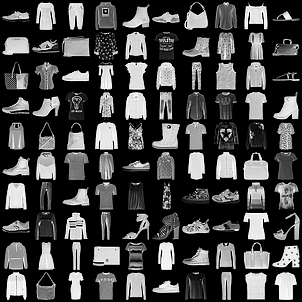

In [75]:
from IPython.display import Image
from torchvision.utils import save_image

# for images in train_dl:
#     images = images.cpu().reshape(len(images),1,28,28)
#     images = (images*0.5) + 0.5
#     save_image(images,"./data/fashion/gans_data/real_images.png",nrow=10)
#     break

Image("./data/fashion/gans_data/real_images.png")

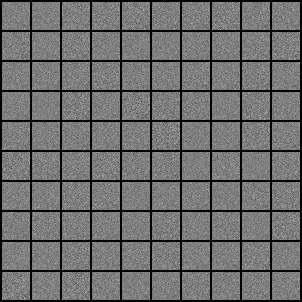

In [76]:
rand = torch.randn(batch_size,latent_size,dtype=torch.float32).to(device)

def save_fake_images(index):

    fake_images = G(rand)
    fake_images = fake_images.reshape(batch_size,1,28,28)
    
    #denormazilation
    fake_images = (fake_images*0.5) + 0.5
    
    save_image(fake_images, "./data/fashion/gans_data/fake_images_"+str(index)+".png", nrow=10)

# save_fake_images(0)
Image("./data/fashion/gans_data/fake_images_0.png")

In [77]:
epochs = 0

torch.cuda.empty_cache()

for epoch in range(epochs):
    
    for images in train_dl:
        
        real_images = images.to(device)
        # print(real_images.shape)
        
        d_loss,real_pred,fake_pred = d_fit(real_images)
        g_loss = g_fit()

    if real_pred.mean()>0.8:
        g_fit()
        g_fit()
    elif real_pred.mean()>0.7:
        g_fit()
    if fake_pred.mean()>0.45:
        d_fit(real_images)
        
    print("Epoch:",epoch+1)
    print("D Loss:",round(d_loss.item(),4),"    G Loss:",round(g_loss.item(),4))
    print("Real_Pred:",round(real_pred.mean().item(),4),"    Fake_Pred:",round(fake_pred.mean().item(),4))
    save_fake_images(epoch+1)

In [78]:
pred_model = G
pred_model.load_state_dict(torch.load("./saved_models/FashionGan.pth", map_location=device))

<All keys matched successfully>

In [79]:
from PIL import Image

def generate():
    rand = torch.randn(50).to(device)
    image = G(rand)
    image = image.reshape(1,28,28)
    image = (image*0.5)+0.5
    save_image(image,"./data/fashion/gans_data/gen.png")
    img = Image.open("./data/fashion/gans_data/gen.png")
    img.resize((280,280)).show("gen.png")


In [80]:
# generate()